In [6]:
# импортируем модули
import os
import re
import shutil
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
# Sequential - модель нейронной сети, в которой слои идут друг за другом
from keras.models import Sequential 
# Тип слоев Dense означает, что слои будут полносвязными
from keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras import utils
# ImageDataGenerator для чтения с диска и подготовки изображений
from keras.preprocessing.image import ImageDataGenerator

In [38]:
# анализируем исходные данные
# разделяем изображения, относящиеся к различным классам, по каталогам (изначально все файлы находятся в одном каталоге)
# разделение понадобится для корректного использования метода flow_from_directory
train_dir = './data/train'
train_dir_list = os.listdir(train_dir)
train_cat_dir = './data/train/cats'
train_dog_dir = './data/train/dogs'
train_cat = 0
train_dog = 0
test_dir = './data/test1'

# функция для перемещения файлов
def moveImage(image, dir):
    target = train_cat_dir if dir == 'cat' else train_dog_dir
    path_to_file = os.path.join(train_dir, image)
    shutil.move(path_to_file, target)

# print('Всего изображений в тренировочном наборе: ', len(train_dir_list))
print('Всего изображений в тренировочном наборе: ', len(os.listdir(train_cat_dir)) + len(os.listdir(train_dog_dir)))
for file in train_dir_list:
    if (len(re.findall(r'cat', file)) == 0):
        train_dog += 1
        # moveImage(file, 'dog')
    else:
        train_cat += 1
        # moveImage(file, 'cat')
# print('Из них кошек: ', train_cat, 'собак: ', train_dog)
# print('Всего изображений в тестовом наборе: ', len(os.listdir(test_dir)))
print('Из них кошек: ', len(os.listdir(train_cat_dir)), 'собак: ', len(os.listdir(train_dog_dir)))

Всего изображений в тренировочном наборе:  17502
Из них кошек:  8751 собак:  8751


In [8]:
# из полученных наборов 30% изображений перенесем в каталоги для валидации
val_dir = './data/validation'
val_cat_dir = './data/validation/cats'
val_dog_dir = './data/validation/dogs'

# функция для перемещения файлов
def moveImageToVal(image, dir):
    target = val_cat_dir if dir == 'cat' else val_dog_dir
    train_dir = train_cat_dir if dir == 'cat' else train_dog_dir
    path_to_file = os.path.join(train_dir, image)
    shutil.move(path_to_file, target)

# for i in range(1, round((train_cat / 100) * 30)):
#     moveImageToVal(os.listdir(train_cat_dir)[i], 'cat')
#     moveImageToVal(os.listdir(train_dog_dir)[i], 'dog')

print('Изображений кошек для валидации: ', len(os.listdir(val_cat_dir)))
print('Изображений собак для валидации: ', len(os.listdir(val_dog_dir)))

Изображений кошек для валидации:  3749
Изображений собак для валидации:  3749


In [16]:
# преобразуем изображения к тензорам с плавающей запятой
# декодируем изображения и преобразуем в нужный формат с учетом RGB-профиля
# нормализуем значения тензора из интервала от 0 до 255 к интервалу от 0 до 1

BATCH_SIZE = 100 # количество тренировочных изображений для обработки перед обновлением параметров модели
IMG_SHAPE = 150 # размерность к которой будет преведено входное изображение

train_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE, IMG_SHAPE),
                                                           class_mode='binary')

val_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                          directory=val_dir,
                                                          shuffle=True,
                                                          target_size=(IMG_SHAPE, IMG_SHAPE),
                                                          class_mode='binary')

Found 17502 images belonging to 2 classes.
Found 7498 images belonging to 2 classes.


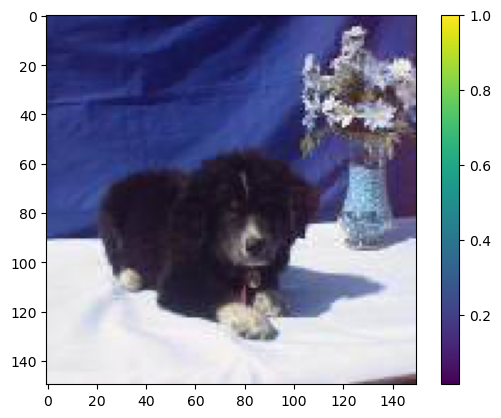

In [6]:
# посмотрим, как выглядят изображение
# получим кортеж изображений с помощью функции matplotlib next
sample_training_images, _ = next(train_data_gen)
plt.figure()
plt.imshow(sample_training_images[0])
plt.colorbar()
plt.grid(False)

# на шкале справа мы видим интенсивность пикселей. Благодаря нормализации она входит в диапазон от 0 до 1, что поможет модели лучше обработать данные

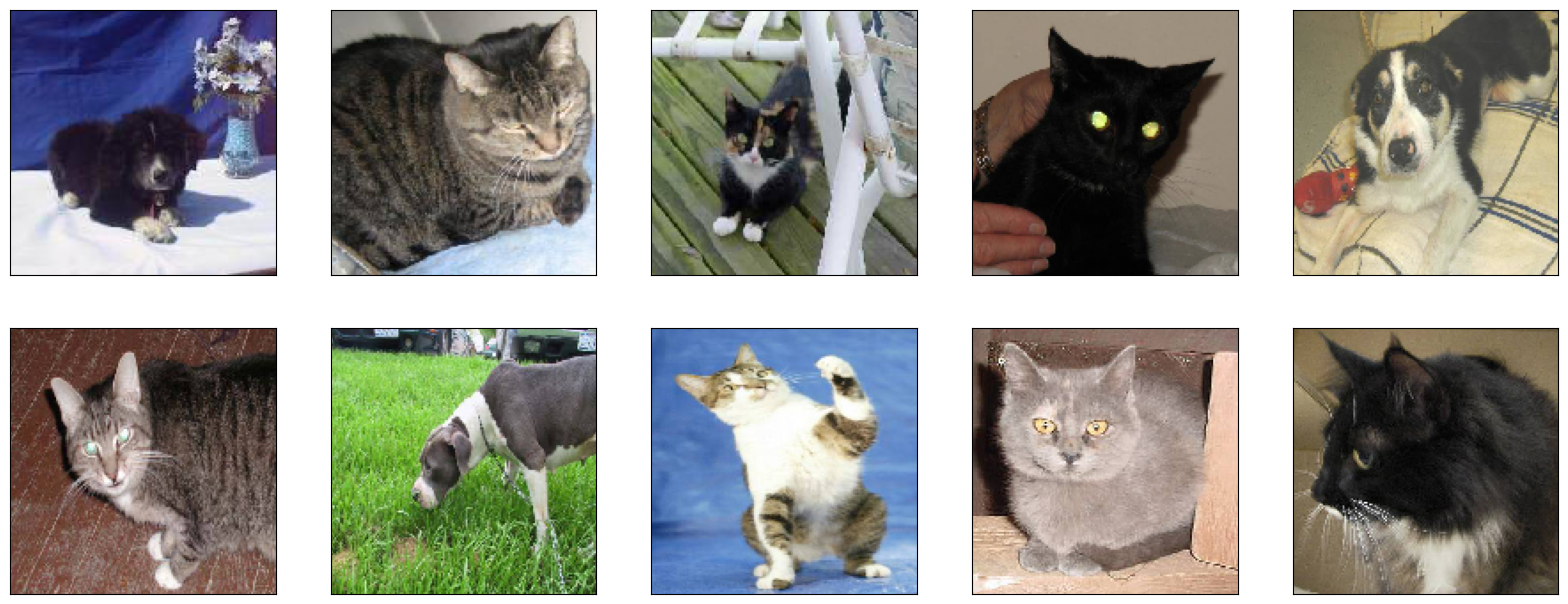

In [7]:
# выведем сразу несколько изображений
plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(sample_training_images[i])

# видим, что изображения одного размера

In [29]:
# создаем модель нейронной сети
# в качестве аргумента передается массив слоев, которые будут обрабатываться последовательно
# в модели 4 сверточных слоя, в которых данные 
# сверточные слои закомментированы, т.к. компт с большим трудом тянет такую модель

model = Sequential([
    # Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)), # слой 2D свертки (например, пространственная свертка над изображениями)
    # MaxPooling2D(2, 2), # операция максимальной подвыборки(субдискретизации) для пространственных данных
    
    # Conv2D(64, (3, 3), activation='relu'),
    # MaxPooling2D(2, 2),
    
    # Conv2D(128, (3, 3), activation='relu'),
    # MaxPooling2D(2, 2),
    
    # Conv2D(128, (3, 3), activation='relu'),
    # MaxPooling2D(2, 2),
        
    Flatten(input_shape=(IMG_SHAPE, IMG_SHAPE, 3)), # формат изображений преобразуется из двухмерного массива в одномерный
    Dense(512, activation='relu'), # входной полносвязный слой (здесь определяется количество нейронов, которые будут в этом слое)
    Dense(1, activation='sigmoid') # выходной полносвязный слой (количество нейронов равно количеству классов)
])
# С помощью softmax вернется массив из двух вероятностных оценок, сумма которых равна 1 (каждая оценка показывает вероятность принадлежности к одному из двух классов)
# с помощью sigmoid возвращается единственное значение (если больше 0,5, то изображение относится к одному классу, если меньше - к другому)

In [30]:
# компиляция модели
# optimizer - оптимизатор, используем стохастический градиентный спуск SGD, можно также использовать оптимизатор adam
# loss - функция ошибки, используем бинарную перекрестную энтропию
# категориальная перекрестная энтропия sparse_categorical_crossentropy предпочтительна когда классов больше двух
# metrics - параметр качества, используем accuracy (доля правильных ответов)
model.compile(optimizer=SGD(), loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
# выведем параметры модели
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 67500)             0         
                                                                 
 dense (Dense)               (None, 128)               8640128   
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 8,640,257
Trainable params: 8,640,257
Non-trainable params: 0
_________________________________________________________________


In [31]:
# обучение модели
# epochs - количество эпох
# steps_per_epoch - количество шагов для выхода из генератора для завершения одной эпохи и начала следующей (вычисляется по формуле)
# validation_steps - используется если данные являются генератором, общее количество шагов (партий сэмплов) для получения данных из генератора до остановки в конце каждой эпохи
total_train = len(os.listdir(train_cat_dir)) + len(os.listdir(train_dog_dir))
total_val = len(os.listdir(val_cat_dir)) + len(os.listdir(val_dog_dir))
model.fit(
    x=train_data_gen, 
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))), 
    epochs=10, 
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)
# с каждой эпохой значение ошибки loss снижается, а точность accuracy повышается

Epoch 1/10
176/176 [==============================] - 56s 315ms/step - loss: 0.7612 - accuracy: 0.5675 - val_loss: 0.6687 - val_accuracy: 0.5910
Epoch 2/10
176/176 [==============================] - 53s 302ms/step - loss: 0.6612 - accuracy: 0.6033 - val_loss: 0.6628 - val_accuracy: 0.5988
Epoch 3/10
176/176 [==============================] - 54s 308ms/step - loss: 0.6541 - accuracy: 0.6158 - val_loss: 0.6601 - val_accuracy: 0.6002
Epoch 4/10
176/176 [==============================] - 55s 310ms/step - loss: 0.6480 - accuracy: 0.6240 - val_loss: 0.6521 - val_accuracy: 0.6155
Epoch 5/10
176/176 [==============================] - 55s 310ms/step - loss: 0.6521 - accuracy: 0.6200 - val_loss: 0.6523 - val_accuracy: 0.6147
Epoch 6/10
176/176 [==============================] - 54s 304ms/step - loss: 0.6424 - accuracy: 0.6294 - val_loss: 0.6518 - val_accuracy: 0.6120
Epoch 7/10
176/176 [==============================] - 57s 325ms/step - loss: 0.6363 - accuracy: 0.6334 - val_loss: 0.6462 - val_ac

75/75 [==============================] - 15s 199ms/step
Результат предсказания;  [0.7147028]
На рисунке:  собака по результатам предсказания:  собака


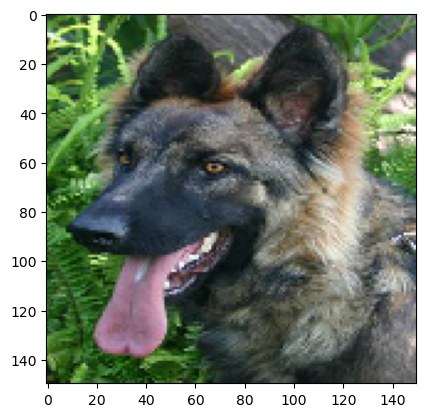

In [37]:
# предсказание на изображениях из валидационной выборки
# посмотрим на изображение
index = 0
sample_val_images, lbl = next(val_data_gen)
fact_class = 'кошка' if lbl[index] == 0 else 'собака'
plt.figure()
plt.imshow(sample_val_images[index])

# получим результат предсказания
predictions = model.predict(val_data_gen)
result = predictions[index]
print('Результат предсказания; ', result)
result_text = 'кошка' if result < 0.5 else 'собака'
print('На рисунке: ', fact_class, 'по результатам предсказания: ', result_text)